## **Synthetic Financial Datasets For Fraud Detection**

### **1. Problem Definition**


This project corresponds to the competition "Synthetic Financial Datasets For Fraud Detection" in Kaggle, and it consists of a synthetic dataset generated by a simulator called PaySim. PaySim uses aggregated data from a private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

**Headers**

According to the original project in Kaggle, the dataset contains the following features. 

> step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

> type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

> amount - amount of the transaction in local currency.

> nameOrig - customer who started the transaction.

> oldbalanceOrg - initial balance before the transaction.

> newbalanceOrig - new balance after the transaction.

> nameDest - customer who is the recipient of the transaction

> oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

> newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

> isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

> isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

**Objective**

The objective of the challenge is to propose a solution to detect and predict the fraudulent bank transactions.

***

### **2. Import Libraries and Data**

In [36]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier, plot_importance, plot_tree

In [2]:
#Read data
data = pd.read_csv("Data/fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


***

### **3. Data Pre-Processing**

In [3]:
#Statistical Summary
data.describe(include="all")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [4]:
#Summary of the dataframe and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


As we can see above, our dataset contains 13 features and 6,362,620 entries.
Moreover, all columns have the correct data type. 

#### 3.1 Missing values

In [5]:
#Count of missing values per column
missing_data = data.isnull()
for column in missing_data.columns.values.tolist():
    print (missing_data[column].value_counts())
    print("")

False    6362620
Name: step, dtype: int64

False    6362620
Name: type, dtype: int64

False    6362620
Name: amount, dtype: int64

False    6362620
Name: nameOrig, dtype: int64

False    6362620
Name: oldbalanceOrg, dtype: int64

False    6362620
Name: newbalanceOrig, dtype: int64

False    6362620
Name: nameDest, dtype: int64

False    6362620
Name: oldbalanceDest, dtype: int64

False    6362620
Name: newbalanceDest, dtype: int64

False    6362620
Name: isFraud, dtype: int64

False    6362620
Name: isFlaggedFraud, dtype: int64



The dataset does not contain any missing values. However, as indicated in the Kaggle project, there is not information in initial/new balance of destination for customers that start with M (Merchants). It is probable that these values were imputed with zero or other value, so we'll check it.

In [6]:
#Count of zeros per column
(data == 0).sum()

step                    0
type                    0
amount                 16
nameOrig                0
oldbalanceOrg     2102449
newbalanceOrig    3609566
nameDest                0
oldbalanceDest    2704388
newbalanceDest    2439433
isFraud           6354407
isFlaggedFraud    6362604
dtype: int64

There is a significant amount of zeros both in destination and origin balances. 

We want to check cases in which OldBalance = NewBalance = 0, as this does not make sense after a transaction, so this could be interpreted also as missing information. 

New features are created for Type of Origin and Destination account in order to check if this missing information is only for M or also for C accounts.

In [7]:
#Feature for Type of Origin account.
data['Origin Type'] = data['nameOrig'].apply(lambda x: x[0])
#Feature for  Type of Destination account.
data['Destination Type'] = data['nameDest'].apply(lambda x: x[0])
data[['Origin Type','Destination Type']].head()

,Origin Type,Destination Type
0,C,M
1,C,M
2,C,C
3,C,C
4,C,M


In [8]:
print('Missing information for destination account balances as fraction af all entries:')
miss_dest = data[(data['oldbalanceDest'] == 0) & (data['newbalanceDest'] == 0)]
miss_dest['Destination Type'].value_counts()/len(data)

Missing information for destination account balances as fraction af all entries:


M    0.338146
C    0.026056
Name: Destination Type, dtype: float64

In [9]:
print('Missing information for origin account balances as fraction af all entries:')
miss_orig = data[(data['oldbalanceOrg'] == 0) & (data['newbalanceOrig'] == 0)]
miss_orig['Destination Type'].value_counts()/len(data)

Missing information for origin account balances as fraction af all entries:


C    0.206635
M    0.121687
Name: Destination Type, dtype: float64

**Conclusion**: There are transactions in which OldBalance = NewBalance = 0, which does not make sense, because depending on the type of transaction, the NewBalance is expected to increase/decreased compared with OldBalance.
Then, the data in these columns can be missing information.

Moreover, the project in Kaggle indicates that this is an issue for customers that start with M (Merchants), but we identify that it also happens for accounts stating with C.

¿How to deal with this?
* Drop data: This happens in 35% of destination balances and 22% of origin balances, so drop these entries will result in loosing a big part of the dataset. Then, this approach is not followed.
* Replace data: We can replace this values with -1, which help us preserve the information and can be a practical approach before applying ML algorithms. Algorithms that cannot handle missing values directly may benefit from this treatment, as they will interpret -1 as a valid value.

In [10]:
#Replacing missing values with -1
data.loc[(data['oldbalanceOrg'] == 0) & (data['newbalanceOrig'] == 0), ['oldbalanceOrg', 'newbalanceOrig']] = - 1
data.loc[(data['oldbalanceDest'] == 0) & (data['newbalanceDest'] == 0), ['oldbalanceDest', 'newbalanceDest']] = - 1
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Origin Type,Destination Type
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,-1.0,-1.00,0,0,C,M
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,-1.0,-1.00,0,0,C,M
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,-1.0,-1.00,1,0,C,C
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,C,C
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,-1.0,-1.00,0,0,C,M
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,-1.0,-1.00,0,0,C,M
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,-1.0,-1.00,0,0,C,M
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,-1.0,-1.00,0,0,C,M
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,-1.0,-1.00,0,0,C,M
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,C,C


#### 3.2 Outlier detection

Outlier detection is an important task in data analysis and machine learning, aimed at identifying observations that significantly deviate from the majority of the data points. Outliers can arise due to various reasons such as measurement errors, natural variation, or rare events, and detecting them is important for several reasons related to data quality, model performance, and the validity of analytical results.

Both New and Old balances in both Origin and Destidation depend on the **'amount'** variable, so to look for outliers, we will focus on this feature, which is a key numerical value in the dataset. 

Different techniques can be used for this task, such as:
* Visualizing the data 
* Z-score
* Robust Z-score
* IQR method
* k-Nearest Neighbors 
* Cluster Analysis
* Isolation Forest
* Ensemble methods

For this case we first visualize the data.

**-Visualization**

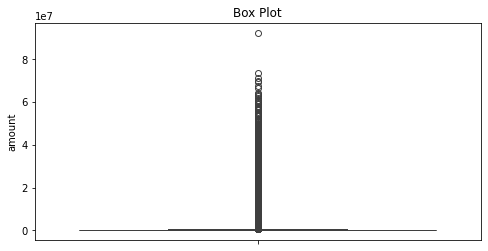

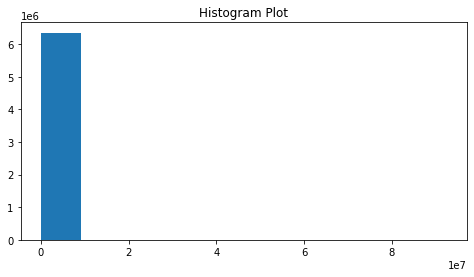

In [11]:
# First, we visualize the data with Box and Histogram plots
def Box_plots(df):
    plt.figure(figsize=(8, 4))
    plt.title("Box Plot")
    sns.boxplot(df)
    plt.show()
Box_plots(data['amount'])

def hist_plots(df):
    plt.figure(figsize=(8, 4))
    plt.hist(df)
    plt.title("Histogram Plot")
    plt.show()
hist_plots(data['amount'])

As we can see in the box plot, there are outliers with values far beyond the Inter Quartile Range "Maximum" and "Minimum". We can also see in the histogram plot that the frequency of these values is so low that seems invisible. 

It is key to detect and handle these outliers because they can affect the quality of data. As we saw in the Statistical Summary first of the first step in Data Preprocessing, currently the magnitud order of median is 10^4, while for mean is 10^5, which is affected by outliers.

The selected method to identify these outliers is Robust Z-Score, which is a variation of the z-score technique and is more resistant to outliers.

**-Robust Z-Score**

The robust z-score, also known as the Median Absolute Deviation (MAD) z-score, is a variation of the z-score that is more resistant to outliers. It uses the median and median absolute deviation (MAD) instead of the mean and standard deviation for calculation. 

Typically, a commonly used threshold for identifying outliers based on absoulue z-scores is 3. If the absolute score is higher than that, the value will be taken as an outlier.

In [12]:
# Function to calculate robust z-score using Median Absolute Deviation (MAD)
def robust_z_score(x):
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    return 0.6745 * (x - median) / mad  # 0.6745 is a constant for asymptotic normality

# Robust Z-Score calculation 
data['Robust_Z_Score'] = robust_z_score(data['amount'])

# Identify outliers with +/-3 threshold 
data['Outlier'] = (data['Robust_Z_Score'] > 3) | (data['Robust_Z_Score'] < -3)

# Number of outliers detected 
count_outliers=data['Outlier'].sum()
print("Number of outliers:", count_outliers)
print("As % of total entries:", count_outliers/len(data)*100,"%")

Number of outliers: 590453
As % of total entries: 9.280029296107578 %


¿How to deal with outliers? 

Common approaches include: 
* Remove outliers 
* Transform data (Normalization, transformation, etc.)
* Imputation 
* Advanced modelling techniques 

Choosing an appropriate replacement value can be subjective and may introduce bias if not carefully handled. Therefore in this case, as the ouliers have values that are way beyond the rest of the data, we decide to remove them in order to minimize impact of extreme values on subsequent analysis.

In [13]:
# Remove outliers
df_cleaned = data[~data['Outlier']]
# Drop additional columns 
df_cleaned.drop(['Robust_Z_Score', 'Outlier'], axis=1, inplace=True)
df_cleaned.head()

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Origin Type,Destination Type
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,-1.0,-1.0,0,0,C,M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,-1.0,-1.0,0,0,C,M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,-1.0,-1.0,1,0,C,C
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,C,C
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,-1.0,-1.0,0,0,C,M


In [14]:
# New Statistical Summary
df_cleaned.describe(include="all")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Origin Type,Destination Type
count,5.772167e+06,5772167,5.772167e+06,5772167,5.772167e+06,5.772167e+06,5772167,5.772167e+06,5.772167e+06,5.772167e+06,5.772167e+06,5772167,5772167
unique,NaN,5,NaN,5764489,NaN,NaN,2710427,NaN,NaN,NaN,NaN,1,2
top,NaN,PAYMENT,NaN,C363736674,NaN,NaN,C985934102,NaN,NaN,NaN,NaN,C,C
freq,NaN,2151495,NaN,3,NaN,NaN,80,NaN,NaN,NaN,NaN,5772167,3620672
mean,2.436402e+02,NaN,9.756277e+04,NaN,8.586529e+05,8.795242e+05,NaN,9.477546e+05,9.904904e+05,6.706320e-04,1.732452e-07,NaN,NaN
std,1.422290e+02,NaN,1.020653e+05,NaN,2.929778e+06,2.962758e+06,NaN,2.972003e+06,2.993632e+06,2.588788e-02,4.162273e-04,NaN,NaN
min,1.000000e+00,NaN,0.000000e+00,NaN,-1.000000e+00,-1.000000e+00,NaN,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
25%,1.560000e+02,NaN,1.164640e+04,NaN,-1.000000e+00,-1.000000e+00,NaN,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
50%,2.390000e+02,NaN,5.493616e+04,NaN,1.517800e+04,0.000000e+00,NaN,7.970504e+04,1.401681e+05,0.000000e+00,0.000000e+00,NaN,NaN
75%,3.340000e+02,NaN,1.653501e+05,NaN,1.134690e+05,1.568764e+05,NaN,7.658899e+05,8.479959e+05,0.000000e+00,0.000000e+00,NaN,NaN


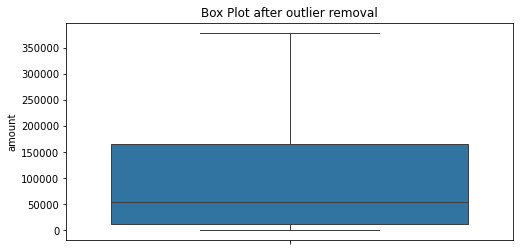

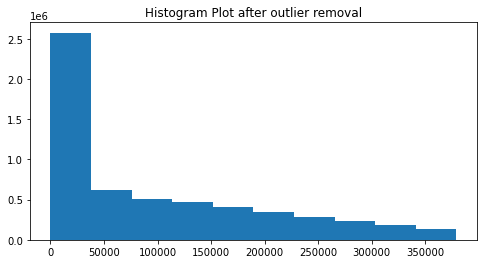

In [15]:
# New plots after outliers removal
def Box_plots(df):
    plt.figure(figsize=(8, 4))
    plt.title("Box Plot after outlier removal")
    sns.boxplot(df)
    plt.show()
Box_plots(df_cleaned['amount'])

def hist_plots(df):
    plt.figure(figsize=(8, 4))
    plt.hist(df)
    plt.title("Histogram Plot after outlier removal")
    plt.show()
hist_plots(df_cleaned['amount'])

**Conclusion** 

For outliers detection we focused on 'amount' variable, since New and Old balances in both Origin and Destidation accounts depend heavily on it.
We detected outliers with Robust Z-Score method and removed them in order to minimize impact of these extreme values on subsequent analysis.
After this, we got a more balanced distribution in 'amount' values compared to the one with outliers. 
***

### **4. Exploratory Data Analysis and Feature Engineering**

#### 4.1 Target variable

First, we want to stablish the target variable of the dataset. We have two variables, 'isFraud', which is actual fraud status, and 'isFlaggedFraud', that it is an indicator to flag the transaction with a threhold of 'amount' = 200.000.

In [16]:
print("'isFlaggedFraud'=1 in original data:",data['isFlaggedFraud'].sum())
print("'isFlaggedFraud'=1 after outlier removal:",df_cleaned['isFlaggedFraud'].sum())

'isFlaggedFraud'=1 in original data: 16
'isFlaggedFraud'=1 after outlier removal: 1


We see that there is only 16 transactions marked as isFlaggedFraud, and 15 of them were identified ealier as outliers and then removed. So we only have 1 mark in almost 6M entries for the cleaned dataset. This gives irrelevant to no-value to our analysis.

Moreover, according to the dataset description, this variable should be 1 for all entries with 'amount'>200.000, and this is not the case. Then, it also seems to be an error in the definition of this variable. 

Considering this, we remove 'isFlaggedFraud' variable, because it is meaningles, and we take 'isFraud' as the target variable of our dataset.

In [17]:
# Drop 'isFlaggedFraud' column
df_cleaned.drop(['isFlaggedFraud'], axis=1, inplace=True)
df_cleaned.head()

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Origin Type,Destination Type
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,-1.0,-1.0,0,C,M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,-1.0,-1.0,0,C,M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,-1.0,-1.0,1,C,C
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,C,C
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,-1.0,-1.0,0,C,M


[Text(0, 0, '5768296 (100%)'), Text(0, 0, '3871 (0%)')]

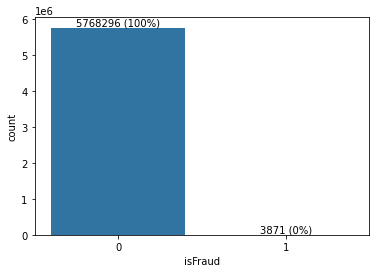

In [18]:
ax = sns.countplot(x='isFraud', data=df_cleaned)
abs_values = df_cleaned['isFraud'].value_counts().values
rel_values = df_cleaned['isFraud'].value_counts(normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)

Considering the values of the target variable 'isFraud', we have a **highly imbalanced** dataset. 
For every fraud transaction, there are 1,490 legit transactions. 
This is a clear _class imbalance_ problem, so we will deal with this later in the analysis in order to select a Machile Learning algorith for prediction. 

#### 4.2 Correlation between variables

**Numerical values**

First, we measure the correlation in numerical values. This is done with Pearson correlation, which is a statistical measure that quantifies the linear relationship between two continuous variables. It assesses the strength and direction of the linear association between the two variables, ranging from -1 to 1, where.

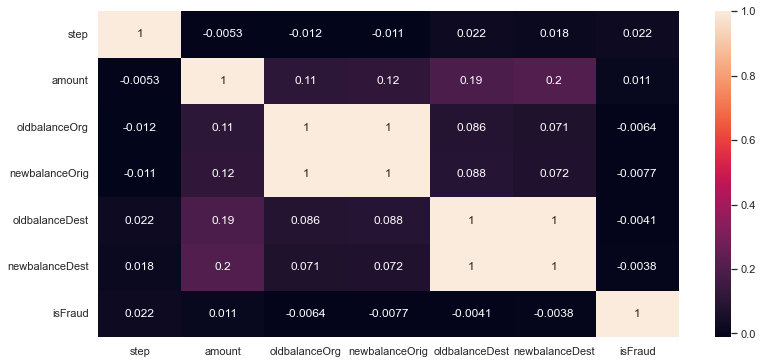

In [19]:
# Pearson Correlation
corr = df_cleaned.corr()

plt.figure(figsize=(13, 6))
sns.set(font_scale=1)
sns.heatmap(corr, annot=True)
plt.show()

With this heatmeat we can visualize the correlation between the dataset numerical variables, which is a measure of the extent of interdependence between variables. 

We see a strong correlation between Old and New balance in both origin and destination accounts, and a soft correlation between the amount of the transaction and the balance variables. 

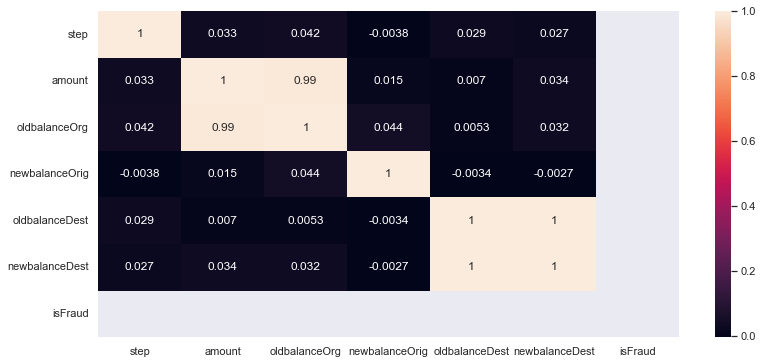

In [20]:
# Only fraud data (3,871 transactions)
fraud = df_cleaned[(df_cleaned['isFraud'] == 1)]
corr = fraud.corr()
plt.figure(figsize=(13, 6))
sns.set(font_scale=1)
sns.heatmap(corr, annot=True)
plt.show()

**Categorical values**

Now we use visualization to check correlation with categorical variables.

<AxesSubplot:xlabel='type', ylabel='count'>

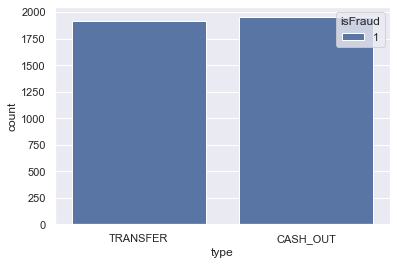

In [21]:
# Fraudulent transactions per Type 
sns.countplot(x='type', hue='isFraud', data=fraud)

<AxesSubplot:xlabel='Origin Type', ylabel='count'>

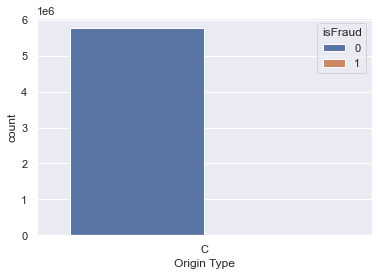

In [22]:
# Fraudulent transactions per Origin Account Type 
sns.countplot(x='Origin Type', hue='isFraud', data=df_cleaned)

<AxesSubplot:xlabel='Destination Type', ylabel='count'>

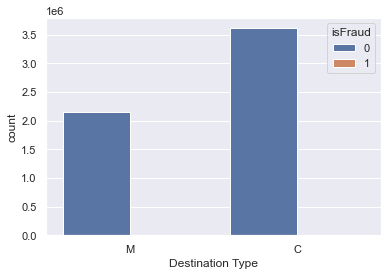

In [23]:
# Fraudulent transactions per Destination Account Type 
sns.countplot(x='Destination Type', hue='isFraud', data=df_cleaned)

We can see that theres is only frauds in 'TRANSFER' and 'CASH_OUT' type of transactions, as well as only for 'C' accounts destination. Therefore, these variables can be good predictors for the target. 

Moreover, we see that there is only 'C' account types in origin, so this variable gives no value to the analysis and we drop it.

#### 4.3 Feature Engineering

From analysis in section 3.1, we see that there are discrepances in the balance information in origin and destination accounts, so we create two new features to identify these differences. 
In case the values are correct, the balance value is 0. 

In [24]:
df_cleaned['BalanceOrig'] = df_cleaned.newbalanceOrig - df_cleaned.oldbalanceOrg + df_cleaned.amount
df_cleaned['BalanceDest'] = df_cleaned.oldbalanceDest - df_cleaned.newbalanceDest + df_cleaned.amount
df_cleaned[['BalanceOrig','BalanceDest']].describe()

/var/folders/yq/rpmf4wr96j51lzklc0fj2p3m0000gn/T/ipykernel_69204/2270686662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['BalanceOrig'] = df_cleaned.newbalanceOrig - df_cleaned.oldbalanceOrg + df_cleaned.amount
/var/folders/yq/rpmf4wr96j51lzklc0fj2p3m0000gn/T/ipykernel_69204/2270686662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['BalanceDest'] = df_cleaned.oldbalanceDest - df_cleaned.newbalanceDest + df_cleaned.amount


,BalanceOrig,BalanceDest
count,5.772167e+06,5.772167e+06
mean,1.184340e+05,5.482689e+04
std,1.554724e+05,2.421057e+05
min,-1.000000e-02,-5.778780e+07
25%,1.156905e+03,0.000000e+00
50%,4.431958e+04,4.954740e+03
75%,1.908683e+05,3.107546e+04
max,7.581345e+05,1.319123e+07


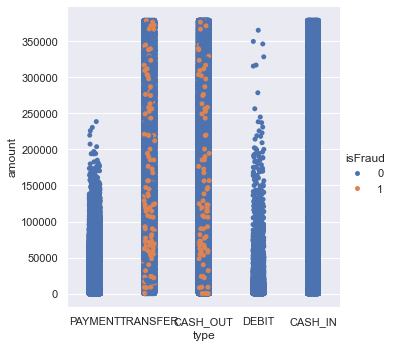

In [25]:
sns.catplot(x = "type", y = "amount", data = df_cleaned, hue = "isFraud")

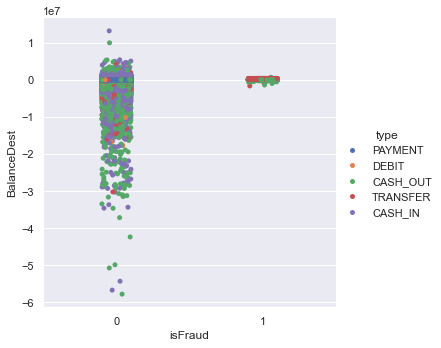

In [26]:
sns.catplot(x = "isFraud", y = "BalanceDest", data = df_cleaned, hue = "type")

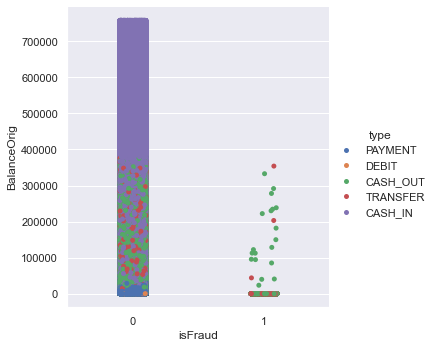

In [27]:
sns.catplot(x = "isFraud", y = "BalanceOrig", data = df_cleaned, hue = "type")

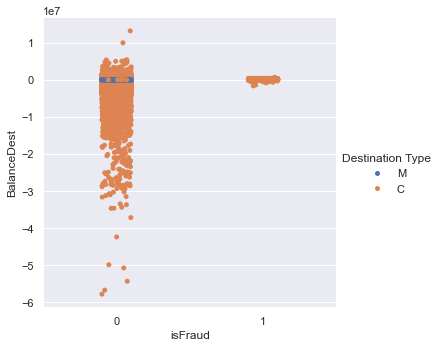

In [28]:
sns.catplot(x = "isFraud", y = "BalanceDest", data = df_cleaned, hue = "Destination Type")

We see a relationship between the target variable and: 
* 'type': Type of transaction (payment, debit, ...)
* 'Destination Type': Destination type account (C, M)
* 'BalanceDest': Error in the calculation of old and new balance considering the amount of transaction for destination accounts.

We turn 'Type' and 'Origin Type' categorical variables into quantitaive ones, as most statistical models cannot take in the strings as input, only numbers. We do this with One-Hot Encoding.

In [29]:
#One-hot enconding for the 3 categorical variables
dummy1 = pd.get_dummies(df_cleaned['type'])

dummy2 = pd.get_dummies(df_cleaned['Destination Type'])
dummy2.rename(columns={'C':'C_dest', 'M':'M_dest'}, inplace=True)

df_cleaned2 = pd.concat([df_cleaned, dummy1, dummy2], axis=1)

# Drop original columns 
df_cleaned2.drop(['type', 'nameOrig', 'nameDest', 'Origin Type', 'Destination Type'], axis=1, inplace=True)
df_cleaned2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,BalanceOrig,BalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,C_dest,M_dest
0,1,9839.64,170136.0,160296.36,-1.0,-1.0,0,-1.455192e-11,9839.64,0,0,0,1,0,0,1
1,1,1864.28,21249.0,19384.72,-1.0,-1.0,0,1.136868e-12,1864.28,0,0,0,1,0,0,1
2,1,181.00,181.0,0.00,-1.0,-1.0,1,0.000000e+00,181.00,0,0,0,0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.000000e+00,21363.00,0,1,0,0,0,1,0
4,1,11668.14,41554.0,29885.86,-1.0,-1.0,0,0.000000e+00,11668.14,0,0,0,1,0,0,1


#### 4.4 Feature selection

In [30]:
Y = df_cleaned2['isFraud'].values 
Y[0:5]

array([0, 0, 1, 1, 0])

In [31]:
X = df_cleaned2.drop(['isFraud'], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,BalanceOrig,BalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,C_dest,M_dest
0,1,9839.64,170136.0,160296.36,-1.0,-1.0,-1.455192e-11,9839.64,0,0,0,1,0,0,1
1,1,1864.28,21249.0,19384.72,-1.0,-1.0,1.136868e-12,1864.28,0,0,0,1,0,0,1
2,1,181.00,181.0,0.00,-1.0,-1.0,0.000000e+00,181.00,0,0,0,0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0.000000e+00,21363.00,0,1,0,0,0,1,0
4,1,11668.14,41554.0,29885.86,-1.0,-1.0,0.000000e+00,11668.14,0,0,0,1,0,0,1


### **5. Model Selection, Development, and Evaluation**

#### 5.1 Model selection

As discussed in section 4.1, this is a **highly imbalanced** dataset. Fraud transactions are less than 0.1% of the total entries.

This is a very common problem in classification, and there are several techniques used to handle this type of data: 
* Redefine the performance metric: For this case the Confusion Matrix, AUROC, or AUPRC can provide better insight than Accuracy metric.
* Resampling techniques (Random under-sampling, Random over-sampling, SMOTE): This can cause loss of information or overfishing.
* Play with the loss function: to use penalized learning algorithms that increase the cost of classification mistakes in the minority class.
* Change algorithm type: Ensemble learning algorithms like bagging and boosting based techniques are good choices for imbalanced classification problems.

The common approach to follow in this type of problem is to apply an oversampling technique as SMOTE. However, this has limitations as SMOTE does not take the similar majority class samples into consideration while creating the synthetic examples of the minority class, it might increase the class overlap and result in additional noise to the training dataset which is again a problem. Secondly, SMOTE is not very effective on high dimensional datasets.

Therefore, different ensemble learning techniques were proved. The best performance was found with ensemble decision tress, which perform well on imbalanced data, specifically XGBoost. XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm known for its performance and scalability in both classification and regression tasks.

#### 5.2 Train/Test split

In [32]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (4617733, 15) (4617733,)
Test set: (1154434, 15) (1154434,)


#### 5.3 Hyperparameter tuning using grid search with cross-validation

In [34]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier()

# Perform grid search with cross-validation (5 folds)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.9124895114028627


Through the Grid Search with Cross Validation, we find the best hyperparameters from the grid indicated.

#### 5.4 Performance metrics

In [37]:

# Make predictions on the test data
y_pred = grid_search.predict(X_test)

# Evaluate the performance metrics  of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("AUROC:", roc_auc_score(y_test, y_pred))

# Make predictions on the test data
y_proba = grid_search.predict_proba(X_test)[:, 1]  # Probability of positive class
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# Calculate AUPRC
print("AUPRC:", auc(recall, precision))

Accuracy: 0.999893454281492
F1 score: 0.9183808891838089
AUROC: 0.9493311462717633
AUPRC: 0.9675589353454097


We calculated several performance metrics for our model
* Accuracy: is the total number of correct predictions by the classifier divided by the total number of predictions. This may be good enough for a well-balanced class but not ideal for the imbalanced class problem.

More appropriate metrics for imbalanced class dataset:
* F1 score: It is the harmonic mean of precision and recall.
* AUROC: area under the receiver operating characteristic.
* AUPCR: area under the precision-recall curve (AUPRC) 

According to the literature, several papers indicate that AUPCR is a superior metric for model comparison vs the AUROC. In our case, we got an AUPCR of 96.8%, which is a good performance overall considering that we are applying the model to the complete data and avoiding over/undersampling.

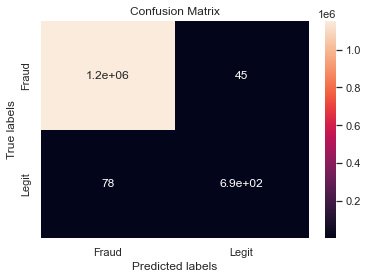

In [38]:
# Calculate Confusion Matrix
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Fraud', 'Legit']); ax.yaxis.set_ticklabels(['Fraud', 'Legit'])
    
plot_confusion_matrix(y_test, y_pred)

#### 5.5 Visualization of the model

Text(0.5, 1.0, 'Feature importance in the XGBoost model')

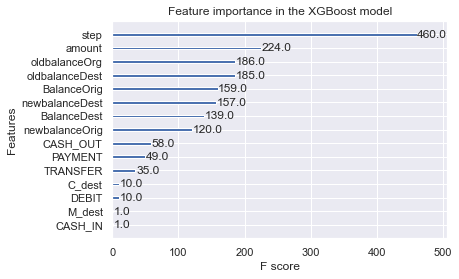

In [51]:
# Get the best estimator from the grid search
best_xgb_classifier = grid_search.best_estimator_
# Train the final XGBoost model using the best hyperparameters
best_xgb_classifier.fit(X_train, y_train)

# Visualize feature importance
ax = plot_importance(best_xgb_classifier)
ax.set_title('Feature importance in the XGBoost model')

python(81033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


<Figure size 864x576 with 0 Axes>

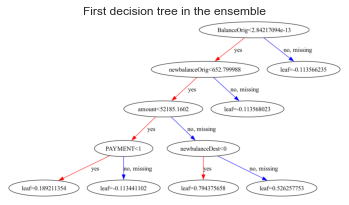

In [61]:
# Visualize first decision tree
plt.figure(figsize=(12, 8)) 
ax = plot_tree(best_xgb_classifier, fontsize=10) 
ax.set_title('First decision tree in the ensemble')
plt.show()

We see that features 'step' and 'amount' are the most important according to F-score.
The features are ordered based on the number of samples affected by splits on those features.

### **7. Deployment, Monitoring, and Automatization**

In order to automate model training, evaluation, versioning, and deployment, Continuous Integration (CI) and Continuous Deployment (CD) practices can be implemented. CI/CD is commonly used in software development to automate the process of integrating code changes, testing them, and deploying the updated application quickly. Initially, these practices were developed for traditional software applications, but they are now becoming increasingly relevant in machine learning (ML) projects as well.

CI/CD for machine learning automates the development, testing, and deployment of ML models. It involves version control, automated testing, and continuous integration (CI) where code changes trigger automatic builds and tests. Continuous deployment (CD) then deploys models to staging and production environments, with monitoring for performance. Iterative improvements ensure high-quality models are consistently deployed, offering faster development cycles and increased confidence in model quality.

**Platforms**

To implement CI/CD for machine learning, you can use platforms like GitLab CI/CD, Jenkins, GitHub Actions, CircleCI, Travis CI, Kubeflow, or TensorFlow Extended (TFX). These platforms offer integration with ML frameworks, version control systems, and monitoring tools, enabling seamless orchestration of the ML pipeline from code changes to production deployment.

**Best Practices** 

Implementing CI/CD for machine learning involves several best practices to ensure smooth development, testing, and deployment of ML models. Here are some key practices:

* Version Control: Use a version control system like Git to track changes to your code, data, and model artifacts. This enables collaboration, reproducibility, and rollback to previous versions if needed.
* Automation: Automate as much of the ML pipeline as possible, including data preprocessing, model training, evaluation, and deployment. This reduces manual errors and speeds up the development cycle.
* Modularization: Break down your ML pipeline into modular components, each with a specific responsibility. This improves maintainability, reusability, and scalability of your codebase.
* Testing: Implement a comprehensive testing strategy for your ML models, including unit tests, integration tests, and validation tests. Test both the code and the data pipeline to ensure robustness and correctness.
* Continuous Integration (CI): Set up CI pipelines to automatically build, test, and validate your code whenever changes are pushed to the repository. This ensures that new features or bug fixes don't introduce regressions.
* Continuous Deployment (CD): Automate the deployment of ML models to staging and production environments after passing all tests. Use canary deployments or A/B testing to gradually roll out changes and monitor their impact.
* Monitoring and Logging: Implement monitoring and logging solutions to track the performance of your deployed models in real-time. Monitor metrics like accuracy, latency, and resource usage to detect issues early and optimize performance.
* Reproducibility: Ensure reproducibility of your ML experiments by recording the environment, dependencies, and hyperparameters used during training. This allows others to reproduce your results and facilitates debugging.
* Security: Implement security best practices to protect sensitive data and prevent unauthorized access to your ML systems. Use encryption, access controls, and secure APIs to safeguard your infrastructure.
* Documentation: Document your ML pipeline, including data sources, preprocessing steps, model architectures, and deployment procedures. This helps onboard new team members, troubleshoot issues, and maintain the system over time.

By following these best practices, you can establish a robust CI/CD pipeline for machine learning that improves productivity, reliability, and scalability across your development team.

### **Conclusions** 

* For this project we have a Synthetic Financial Datasets For Fraud Detection. We found several discrepancies between column descriptions and actual values, so a detailed data cleaning was required.
* The dataset was highly imbalanced, which represented a challenge for the development of binary classification algorithm. Several approaches were evaluated to hadle the skew, and a ensemble boosting method was selected without over/under sampling the data, thus avoiding loss of information or overfishing.
* After making the appropiate missing and outliers handling, as well as feature engineering, we developed an XGBoost model through Grid Search and Cross Valitation, which yields a predictive performance of 98.8%, measured with area under the precision-recall curve (AUPRC).